# Enamel Thickness Boxplot

The plot that will be reproduced here is a grouped boxplot of molar enamel thickness for humans, fossil hominins, and the extant great apes from Skinner et al. (2015) in JHE (doi: [10.1016/j.jhevol.2015.03.012](http://dx.doi.org/10.1016/j.jhevol.2015.03.012)). I'm a little unsure of some of the color and formatting choices in the published plot, but it's a good dataset and I want an example plot to go along with each of the entries in my bioanth datasets repository.

![](images/enamelthickness_plot.png)

The data underlying this plot are included in the supplementary material of the paper and have been extracted and made available in my bioanth datasets repository.

## Preliminaries

First, I always change the R option for importing strings (I find that the default convert to factor causes more problems than it solves).

In [1]:
options(stringsAsFactors=F)

You can safely ignore this next option. The default image rendering option for the system I am using here (Jupyter Notebook) does not show italic annotations on plots properly; this option change fixes that. Standard R on your system will work as it should without this option change.

In [2]:
options(jupyter.plot_mimetypes = 'image/png')

Next, import the data. The resulting data frame has nine variables: accession, tooth, enamel_area (mm$^2$), dentine_area (mm$^2$), edj_length (enamel-dentine junction, mm), bcd (bi-cervical diameter, mm), aet (average enamel thickness, mm), and ret (relative enamel thickness).

In [3]:
dset = read.csv(url("https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/enamelthickness.csv"))
str(dset)

'data.frame':	195 obs. of  9 variables:
 $ accession   : chr  "AL145-35" "AL333w-1a" "AL128-23" "AL145-35" ...
 $ taxon       : chr  "A. afarensis" "A. afarensis" "A. afarensis" "A. afarensis" ...
 $ tooth       : chr  "M1" "M1" "M2" "M2" ...
 $ enamel_area : num  26.2 24.3 20.7 29.8 29.4 ...
 $ dentine_area: num  46.7 39.3 29.7 46.5 33.4 ...
 $ edj_length  : num  20.9 18.8 16.4 20.1 17.9 ...
 $ bcd         : num  11.5 11.2 11.2 12.1 12.6 ...
 $ aet         : num  1.26 1.29 1.26 1.48 1.64 1.54 1.55 1.52 1.29 1.78 ...
 $ ret         : num  18.4 20.6 23.2 21.7 28.4 ...


The full dataset includes some specimens with "Uncertain" taxonomic affiliation that are not included in the targeted boxplot and *A. aethiopicus* is also dropped. So it's easiest to subset out those samples for the plotting going forward.

In [4]:
dset2 = subset(dset, !(taxon %in% c("Uncertain", "A. aethiopicus")))
nrow(dset)
nrow(dset2)

[1] 195

[1] 185

For the plot, the chimpanzee species need to be merged and an ordered factor will be useful to have everything plot in the same order. It will also be useful to have the tooth variable as a factor.

In [5]:
# make up a mapping vector to get new labels
taxa = c("A. afarensis", "A. africanus", "A. anamensis", "Gorilla sp.",      
         "Homo sapiens ", "Pan paniscus", "Pan troglodytes", "Pongo sp.", 
         "Homo erectus", "Homo sp. indet.", "A. boisei", "A. robustus")
map_labels = c("Aafar", "Aafri", "Aana", "Gorilla",
               "Hsap", "Pan", "Pan", "Pongo", 
               "Here", "Hsp", "Aboi", "Arob")
names(map_labels) = taxa

# new group labels for all specimens in the reduced data set
newgroups = map_labels[dset2$taxon]

# set up the desired order
desiredorder = c("Aana", "Aafar", "Aafri", "Aboi", "Arob", "Hsp", 
                 "Here", "Hsap", "Pongo", "Gorilla", "Pan")

# make the new groups into an ordered factor
newgroups = factor(newgroups, levels=desiredorder, ordered=T)

# add it to the data frame
dset2$otaxon = newgroups

# make the tooth variable a factor
dset2$tooth = factor(dset2$tooth)

Set up colors, font styles, legend labels, and calculate positions for taxon labels on the plot.

In [6]:
barcols = c("steelblue4", "forestgreen", "lightgoldenrod3")
keynames = c("First molar", "Second molar", "Third molar")
fontstyle = c(1,1,1,1,1,1,1,1,3,3,3)              # for base R & lattice (1=normal, 3=italic)
fontformat = c(rep("plain", 8), rep("italic", 3)) # for ggplot2

# pull out group labels and calculate number in preparation for plotting each
groups = levels(dset2$otaxon)
ngroups = length(groups)

# calculate locations for annotations
xloc = 1:ngroups
yloc = aggregate(aet ~ otaxon, min, data=dset2, simplify=T)$aet-0.1

## Base R

Base R plotting does not readily support this kind of plot, but it can be done with some trickery. Specifically, each taxon will be plotted in a separate panel of a multi-panel plot, but the axes will be left off and it will appear to all be a single plot. The resulting plot looks right here, but is probably a little fragile to changing plot sizes and dimensions.

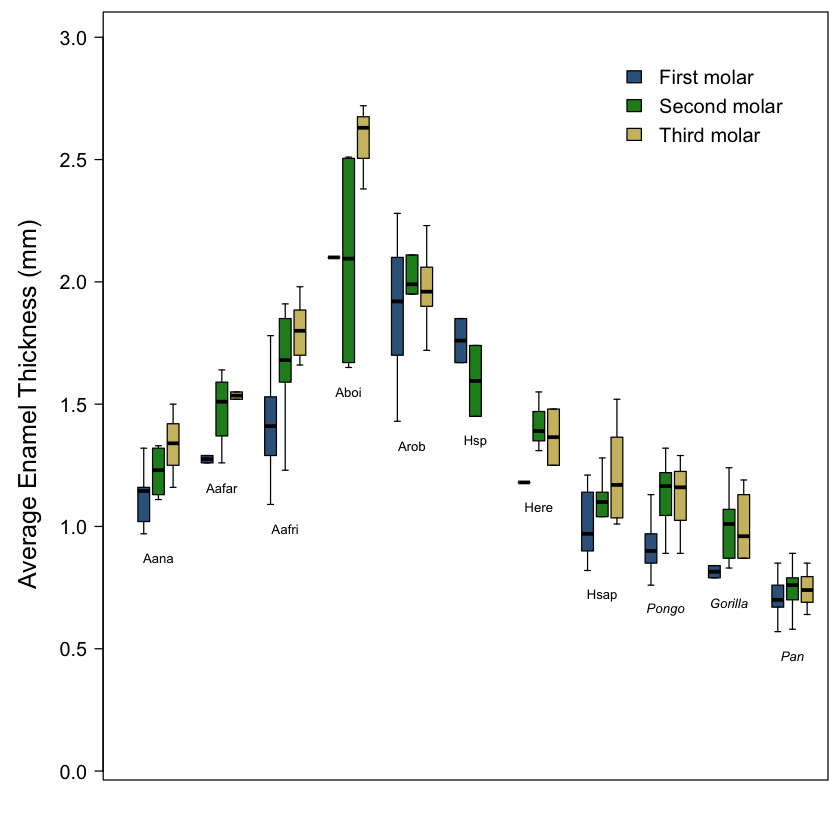

In [7]:
# set up plot parameters, saving the defaults as 'oldpar'
oldpar = par(mfrow=c(1,ngroups), oma=c(2,8,0,1), mar=rep(0.5,4))

# need to use the same y-limits for each of the per-group plots
ylim = c(0, 3)

# plot out each group, adding an axis for the first one
for (i in 1:ngroups) {
    gdata = subset(dset2, otaxon==groups[i])
    boxplot(aet ~ tooth, data=gdata, ylim=ylim, axes=F, col=barcols, outline=F, lty=1)
    text(2,min(gdata$aet)-0.1,groups[i], font=fontstyle[i])
    if (i == 1){
        axis(2, line=2, las=1, cex.axis=1.5)
        mtext("Average Enamel Thickness (mm)", 2, 6, cex=1.25)
    }
}

# reset plotting parameters back to saved defaults
par(oldpar)

# Getting the legend in place also requires some trickery
# It is necessary to place a new blank plot over the top of the 
# existing barplots and then place the legend on that
# I also take advantage of this trickery to draw a box around the prior plotting area

# set up a new figure area with 
#   x- and y-limits from 0 to 1 (fig)
#   outer margins set to bottom 2, left 3.8, top 0, right 0 (oma)
#     - some trial and error to get those number to get the bounding box to plot right
#   spacing around sub-figures set to 0.5 (mar)
#   overplot on existing plot (new=TRUE)
oldpar = par(fig=c(0, 1, 0, 1), oma=c(2, 3.8, 0, 0), mar=rep(0.5,4), new=TRUE)
# add empty plot with no points and no axes, but draw bounding box
plot(0, 0, type='n', xaxt='n', yaxt='n')
# add the legend with no box (bty='n'), inset from the edge by 0.5 
#   and slightly more than usual spacing between the lines
legend("topright", fill=barcols, legend=keynames, 
       bty="n", inset=0.05, y.intersp=1.2)
# reset to saved default plotting parameters
par(oldpar)

## ggplot2

This plot is probably easiest in ggplot2, which supports it pretty seamlessly. Even with all the extra fiddling to attempt to exactly match the published plot, the code is pretty short.

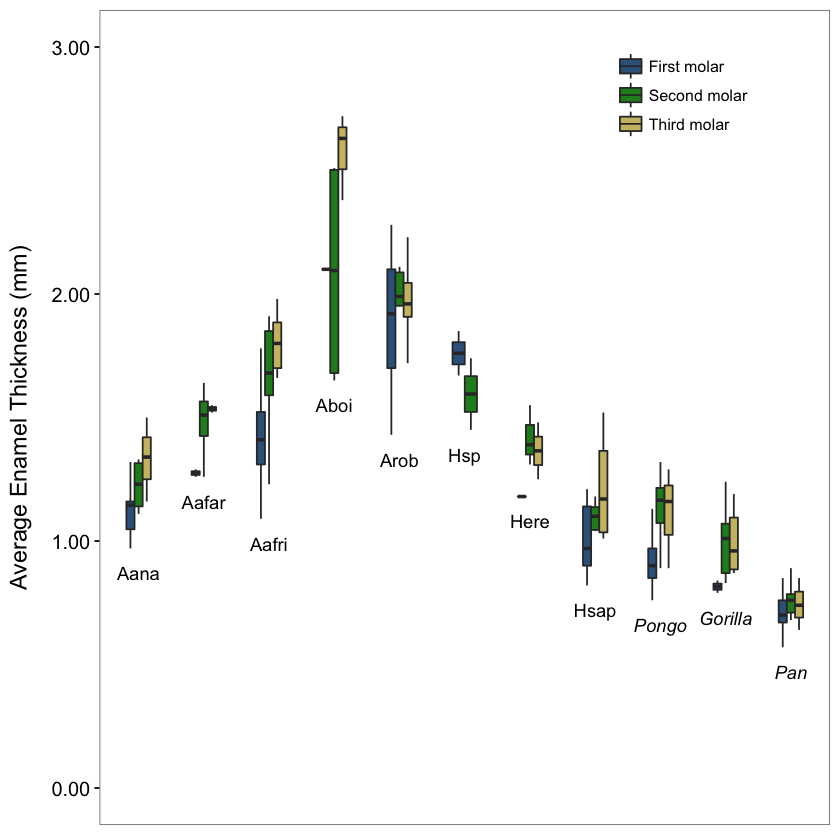

In [8]:
library(ggplot2)

# this part is probably overkill..
# ggplot2 uses only the necessary decimal points on axis labels,
# but the target plot has 2 decimal places, so if we want to exactly match that
# we need a formatting function
fmt = function(x) { format(x, nsmall=2) }

# start the plot, identify the data and variables
plt = ggplot(dset2, aes(x=otaxon, y=aet)) +
        # split each x group out by tooth, with extra spacing (width), and no outliers
        geom_boxplot(aes(fill=tooth), width=0.5, outlier.shape=NA) +
        # manually set the colors to use and legend labels
        scale_fill_manual(values=barcols,
                          labels=keynames) + 
        # configure the y axis with
        #  - custom title
        #  - set the limits
        #  - and use the formatter created above to ensure 2 decimal places on tick labels
        scale_y_continuous(name="Average Enamel Thickness (mm)",
                           limits=c(0,3),
                           labels=fmt) +
        # add the group names directly below each set of box-and-whiskers
        annotate("text", x=xloc, y=yloc, label=groups, fontface=fontformat) +
        # change to simple theme (theme_bw = theme black & white)
        theme_bw() +
        # make more appearance changes
              # get rid of the grid
        theme(panel.grid=element_blank(),
              # change the size and add some spacing to the right of the y axis title
              axis.title.y=element_text(size=14, margin=margin(0,15,0,0)),
              # change the size of the y axis tick labels
              axis.text.y=element_text(size=12),
              # get rid of the x axis ticks
              axis.ticks.x=element_blank(),
              # get rid of the x axis tick labels
              axis.text.x=element_blank(),
              # get rid of the x axis title
              axis.title.x=element_blank(),
              # put the legend inside the plot area
              legend.position=c(0.8,0.9),
              # get rid of the legend title
              legend.title=element_blank(),
              # get rid of the boxes around the legend elements
              legend.key=element_blank())
            
plt

## lattice

lattice also supports this kind of plot pretty seamlessly, but the way that it allows it is a little hard to wrap one's mind around. Basically, what lattice would generally like to do for this situation is do a series of smaller panels for each taxon or each tooth, but it is possible to tell it to instead layer those separate panels on top of each other (superpose). 

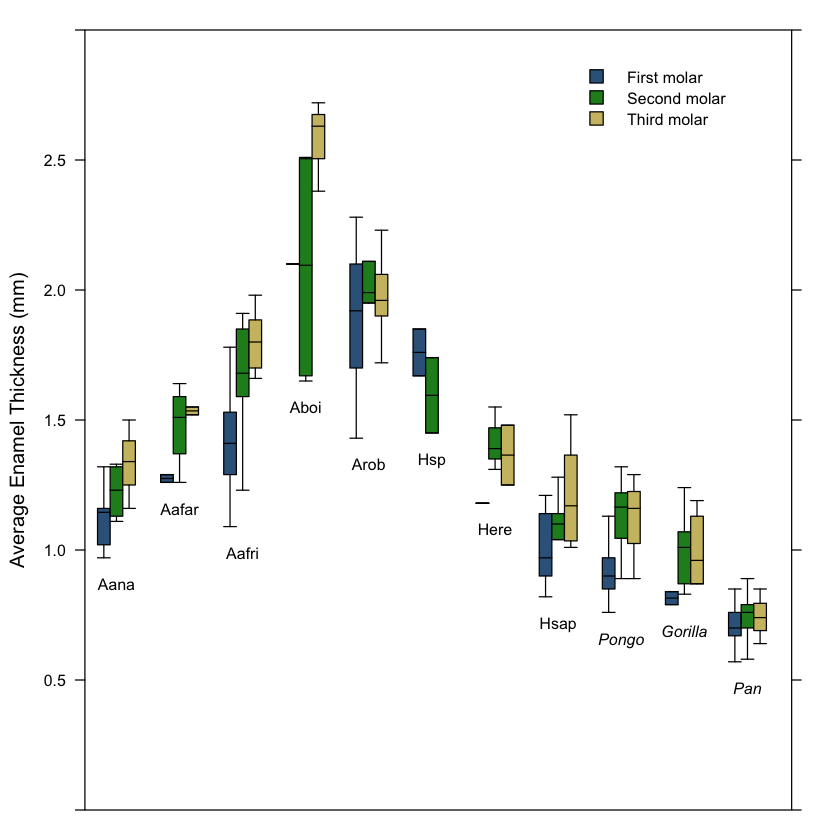

In [9]:
library(lattice)

# specify the information for the key
key = list(points = list(
             pch = 22,                  # square with separate border and fill colors
             cex = 1.5,                 # make it a bit bigger than default
             col = "black",             # square border color
             fill=barcols),             # square fill color
           text = list(text=keynames,   # legend labels
                       cex=0.8),        # make them a bit smaller than default
           corner=c(0.9,0.95),          # put the key in the upper right corner
           padding=2)                   # add a little extra space between entries

# start plotting, separating out aet values by taxon from the data
bwplot(aet~otaxon, data=dset2, 
       # break down each taxon by tooth
       groups=tooth,
       # set the y axis label
       ylab=list(label="Average Enamel Thickness (mm)"),
       # set the y axis limits
       ylim=c(0,3),
       # don't show the outliers
       do.out=F,
       # use a line for the median marker in the bar rather than a point
       pch="|",
       # make each bar 1/5 the default width
       #  - this is necessary to fit 3 bars and some intergroup spacing into 
       #    the space where one bar would normally fit
       box.width=1/5,
       # do some customization of the plotting area
       panel = function(x,y,...) {
           # superpose indicates that we want to plot the different groups in the
           #   same panel, rather than splitting them across panels
           # also set the fill for the different groups (teeth)
           panel.superpose(x,y,fill=barcols,...)
           # then, for each taxon
           for (i in 1:ngroups) {
               # add the group name below where the bars for that group will be
               panel.text(xloc[i]-0.1, yloc[i], groups[i], cex=0.8, font=fontstyle[i])
           }
       },
       # customize the plotting of each tooth group
       panel.groups = function(x, y,..., group.number) { 
         # boxplots for each tooth, with the x values offset a bit so they don't overlap
         panel.bwplot(x + (group.number-2.5)/5, y, ...) 
       },
       # change the appearance of the box-and-whiskers to have
       # - black outlines on the box
       # - black, solid line whiskers
       par.settings = list(box.rectangle=list(col="black"),
                           box.umbrella=list(col="black", lty=1)),
       # don't draw x axis ticks, labels, or title
       scales = list(x=list(draw=FALSE)),
       # add the previously specified key
       key = key
) 